In [1]:
import cv2
import os
from pathlib import Path

# 設定參數
video_paths = {
    "boredom": "/content/boredom.mp4",
    "engagement": "/content/engagement.mp4",
    "confusion": "/content/confusion.mp4"
}
output_dir = "/content/emotion_extension"

os.makedirs(output_dir, exist_ok=True)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_faces_from_video(video_path, label):
    save_path = os.path.join(output_dir, label)
    Path(save_path).mkdir(parents=True, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    count = 0
    frame_interval = 5  # 每 5 幀擷取一張

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if count % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

            for i, (x, y, w, h) in enumerate(faces):
                face_img = frame[y:y+h, x:x+w]
                face_img = cv2.resize(face_img, (224, 224))
                filename = f"{label}_{count}_{i}.jpg"
                cv2.imwrite(os.path.join(save_path, filename), face_img)

        count += 1

    cap.release()
    print(f"✅ {label} done: {count} frames processed.")

# 執行擷取
for label, path in video_paths.items():
    extract_faces_from_video(path, label)


✅ boredom done: 719 frames processed.
✅ engagement done: 737 frames processed.
✅ confusion done: 697 frames processed.


In [2]:
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
import os
from tqdm import tqdm

input_dir = "/content/emotion_extension"
output_dir = "/content/emotion_extension_augmented"
os.makedirs(output_dir, exist_ok=True)

augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.Resize((224, 224))
])

# 為每個類別執行增強
for emotion in os.listdir(input_dir):
    input_path = os.path.join(input_dir, emotion)
    output_path = os.path.join(output_dir, emotion)
    os.makedirs(output_path, exist_ok=True)

    for img_file in tqdm(os.listdir(input_path), desc=f"Augmenting {emotion}"):
        img_path = os.path.join(input_path, img_file)
        img = Image.open(img_path).convert('RGB')
        for i in range(3):  # 每張原圖生成 3 張增強圖片
            aug_img = augmentations(img)
            aug_img.save(os.path.join(output_path, f"{img_file[:-4]}_aug{i}.jpg"))

print("✅ Augmentation completed.")


Augmenting engagement: 100%|██████████| 145/145 [00:00<00:00, 165.00it/s]

✅ Augmentation completed.


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0
from tqdm import tqdm

# ✅ 設定 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 資料路徑與轉換
data_dir = "/content/emotion_extension_augmented"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

# ✅ 載入完整資料集
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# ✅ 切分為訓練集與驗證集（80/20）
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ✅ 載入舊模型並替換分類器（7→3）
pretrained_model_path = "/content/raf-db_efficientnet_b0.pth"
model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)
model.load_state_dict(torch.load(pretrained_model_path))  # 先依原架構載入

# ✅ 轉為 3 類新情緒分類
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)

# ✅ 凍結 feature extractor
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)

# ✅ 開始訓練
epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # ✅ 驗證階段
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"✅ Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# ✅ 儲存模型
save_path = "/content/models/efficientnet/emotion_extension_transfer_split.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"🎉 Model saved to {save_path}")


[Train] Epoch 1/5: 100%|██████████| 30/30 [00:03<00:00,  7.78it/s]


✅ Epoch 1: Train Acc: 0.4466, Val Acc: 0.6709


[Train] Epoch 2/5: 100%|██████████| 30/30 [00:04<00:00,  7.31it/s]


✅ Epoch 2: Train Acc: 0.6571, Val Acc: 0.7595


[Train] Epoch 3/5: 100%|██████████| 30/30 [00:03<00:00,  8.09it/s]


✅ Epoch 3: Train Acc: 0.7291, Val Acc: 0.7848


[Train] Epoch 4/5: 100%|██████████| 30/30 [00:03<00:00,  8.16it/s]


✅ Epoch 4: Train Acc: 0.7407, Val Acc: 0.7932


[Train] Epoch 5/5: 100%|██████████| 30/30 [00:04<00:00,  6.93it/s]


✅ Epoch 5: Train Acc: 0.7683, Val Acc: 0.8312
🎉 Model saved to /content/models/efficientnet/emotion_extension_transfer_split.pth



📋 Classification Report:

              precision    recall  f1-score   support

     boredom       0.80      0.84      0.82        80
   confusion       0.76      0.79      0.77        75
  engagement       0.76      0.69      0.72        81

    accuracy                           0.77       236
   macro avg       0.77      0.77      0.77       236
weighted avg       0.77      0.77      0.77       236



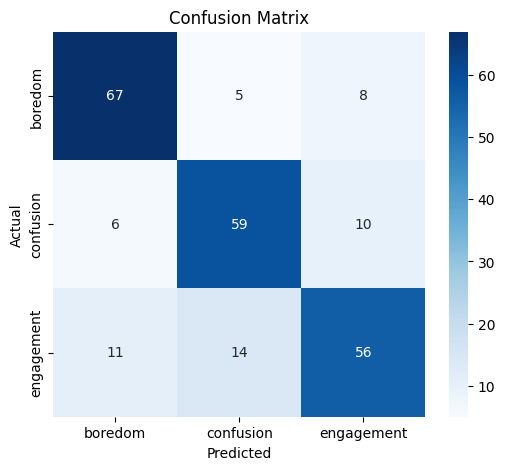

In [7]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ✅ 設定 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 前處理與資料載入
data_dir = "/content/emotion_extension_augmented"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(data_dir, transform=transform)

# ✅ 切分資料集（80% train / 20% val）
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
_, val_dataset = random_split(dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ✅ 模型載入
model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)
model.load_state_dict(torch.load("/content/models/efficientnet/emotion_extension_transfer_split.pth"))
model = model.to(device)
model.eval()

# ✅ 評估指標計算
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ✅ 報告與混淆矩陣
target_names = dataset.classes
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
